In [1]:
import logging
import numpy as np
import tensorflow as tf
import os
import scipy.io
import matplotlib.pyplot as plt
from NOPsolver import NOP_Update
from config import get_config
from init import get_init
from utils import del_all_flags

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.1) 


del_all_flags(tf.flags.FLAGS)
#FLAGS = tf.app.flags.FLAGS
flags = tf.compat.v1.flags
flags.DEFINE_string('problem_name', 'Trig_ConstantFreq',
                           """The name of targeted signal.""")
flags.DEFINE_integer('num_run', 1,
                            """The number of experiments to repeatedly run for the same problem.""")
FLAGS = flags.FLAGS
problem_name = FLAGS['problem_name'].value

In [2]:
## Mimic a signal of two modes with very similar frequency F1 and F2
init_Freq = 40
F1 = 39.8  # frequency of first mode --------- to be retrieved
F2 = 39.99    # frequency of second mode --------- to be retrieved

# generate signal
short = 1
N = 2**10 //short
K = 2
time = np.arange(0,1./short,1./(N*short)) # try downsampling

true_ins_Freq = np.zeros([2,N])
true_ins_Freq[0,:] = np.ones(N) * F1
true_ins_Freq[1,:] = np.ones(N) * F2

true_ins_Phase = np.zeros([2,N])
true_ins_Phase[0,:] = time * F1
true_ins_Phase[1,:] = time * F2

true_Mode = np.zeros([2,N])
true_Mode[0,:] = np.cos(2*np.pi*true_ins_Phase[0,:])
true_Mode[1,:] = np.sin(2*np.pi*true_ins_Phase[1,:])

true_f = np.sum(true_Mode,axis = 0)

# try adding noise
var = 0.1
noise = np.random.randn(N)*var
signal = true_f + var*noise
#plt.plot(true_f)
#only two periods are used to estimate F1 and F2


# initialize algorithm
Sig = {}
Sig['signal'] = signal # input signal to be estimated
Sig['time'] = time
Sig['K'] = K # input number of modes
Sig['D'] = 1 # input order of phase function

logging.basicConfig(level=logging.INFO,format='%(levelname)-6s %(message)s')
config = get_config(problem_name,Sig)

#init_Freq = 40
init = get_init(problem_name,Sig,config,init_Freq)
trainer = NOP_Update(Sig,config, init)

INFO   Signal has 1024 samples, divided into 20 chips each with 102 samples
INFO   But we only compute the first chip
INFO   Update Pattern:    False
INFO   Update Amplitude:  False


[[ 1. 40.]
 [ 1. 40.]]


In [3]:
# update variables
for idx_run in range(1, FLAGS['num_run'].value +1):
    logging.info('Begin to solve %s with run %d' % (problem_name, idx_run))
    for i in range(1):
        trainer.update_phase()
        trainer.update_shape()

INFO   Begin to solve Trig_ConstantFreq with run 1


WARNING From /home/ec2-user/SageMaker/NOPsolver.py:108: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.



WARNING From /home/ec2-user/SageMaker/NOPsolver.py:109: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



WARNING From /home/ec2-user/SageMaker/NOPsolver.py:152: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.



WARNING From /home/ec2-user/SageMaker/NOPsolver.py:152: The name tf.trainable_variables is deprecated. Please use tf.compat.v1.trainable_variables instead.



WARNING From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/horovod/tensorflow/__init__.py:163: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



WARNING From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/horovod/tensorflow/__init__.py:189: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



[2022-01-30 23:43:09.885 ip-172-16-75-235:27707 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-01-30 23:43:09.923 ip-172-16-75-235:27707 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.



WARNING From /home/ec2-user/SageMaker/NOPsolver.py:158: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



WARNING From /home/ec2-user/SageMaker/NOPsolver.py:158: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



WARNING From /home/ec2-user/SageMaker/NOPsolver.py:159: The name tf.global_variables_initializer is deprecated. Please use tf.compat.v1.global_variables_initializer instead.

INFO   Updating Chip 1 of 1: 
INFO   step:     0,    loss: 2.8960e-03,  elapsed time   3
INFO   step:  1000,    loss: 9.9452e-05,  elapsed time   3
INFO   step:  2000,    loss: 9.9454e-05,  elapsed time   3
INFO   step:  3000,    loss: 9.9475e-05,  elapsed time   3
INFO   step:  4000,    loss: 9.9455e-05,  elapsed time   3




Component    1
Update B    [ 1. 40.]   ---->     [ 0.999824 39.799942]
Estimated frequency =  39.799942
Component    2
Update B    [ 1. 40.]   ---->     [ 1.0008144 39.972046 ]
Estimated frequency =  39.972046


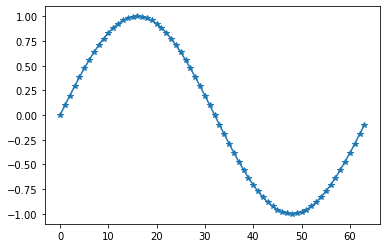

In [4]:
pattern = trainer.u
component = trainer.modes
phase = trainer.phase
amp = trainer.amp
plt.plot(np.squeeze(np.asarray(pattern[1,:])),'-*')

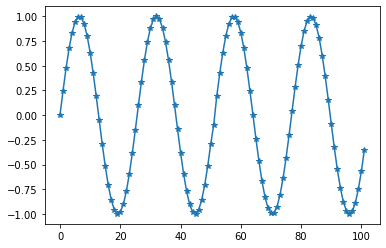

In [5]:
plt.plot(np.squeeze(np.asarray(component[1,:])),'-*')